Device = cpu
Time to generate x(t): 7.068544149398804 s
Time for  sim: 36.52329206466675 s
max real lam1(W) 0.5030760169029236
max real lam2(W) 0.5029179453849792
max real lam3(W) 0.8663175702095032
Found stable matrix after 5 tries
max real lam3(W) 0.8663175702095032
Sim 3: Angle btwn largest sing vec and u1,u2: 93.9718667898673 90.01758341140177 degrees
Sim 3 Angle btwn largest sing vec and u1xu2: 89.82251739501953 degrees
Sim 3: Angle btwn largest sing vec and u1,u2: 93.9718667898673 90.01758341140177 degrees
Sim 3 Angle btwn largest sing vec and u1,u2: 87.8914566040039 degrees
Sim 3: Angle btwn largest sing vec and u1xu2: 93.9718667898673 90.01758341140177 degrees
max real lam4(W) 0.49275195598602295


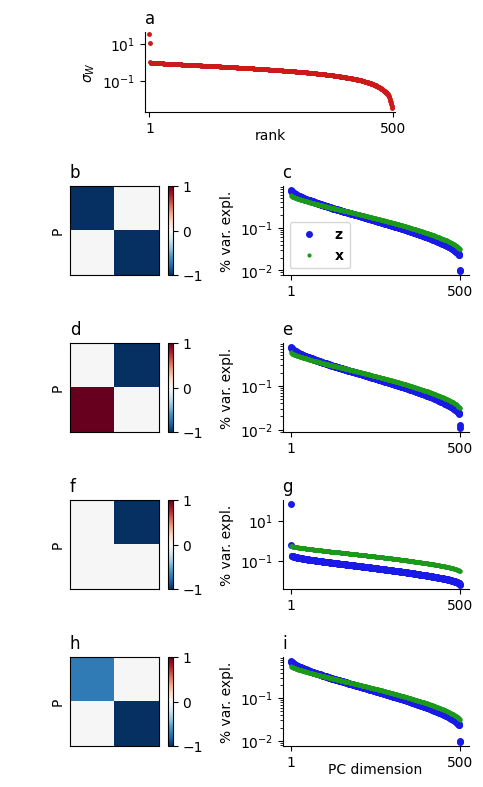

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm


import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA, GetOrthonormalVectors

# Save figures?
SaveFigs=True


device='cpu'
print('Device =',device)

# seed rng
torch.manual_seed(0)


####### Set parameter values

# Number of neurons in recurrent net
N = 500

# Parameters
rho=0.5

# Time step size, timescale of dynamics
dt = 0.01
tau=1

# Simulation time
T=10000

# Timescale and strength of Guassian random stimulus
taux=5
sigmax=1


###### Generate variables 

time=np.arange(0,T,dt)
Nt=len(time)

eta = dt/tau

# Random part of W
W1 = rho*torch.randn(N,N)/np.sqrt(N)

# Low rank part
sigmas = np.sqrt(N)*torch.tensor([1.5,0.5])
Sigma = torch.diag(sigmas)

# Generate 4 orthonormal vectors
OrthVecs = GetOrthonormalVectors(N,4)

# Generate Gaussian noise
with torch.no_grad():
    t0=tm()
    x = sigmax*MakeSmoothGaussianProcess(taux,Nt,dt,N,device=device).T
    x = x[None,:,:].float().to(device)
    tx = tm()-t0
    print('Time to generate x(t):',tx,'s')

# Compute PCA of stimulus, x
with torch.no_grad():   
    Ux,Sx=TorchPCA(x[0,:,:], scaled=False)


    
### Sim 1: Normal matrix
U = torch.zeros(N,2)
U[:,0] = OrthVecs[0,:]
U[:,1] = OrthVecs[1,:]
V = torch.zeros(N,2)
V[:,0] = -OrthVecs[0,:]
V[:,1] = -OrthVecs[1,:]
W0 = U@Sigma@V.T
W = W0+W1
P1 = U.T@V
model = RateModel(W, f='tanh', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)
with torch.no_grad():
    t0=tm()
    r = model(x, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z = model.hidden_state_history
    tsim = tm()-t0
    print('Time for  sim:',tsim,'s')
    Uz1,Sz1=TorchPCA(z[0,:,:], scaled=False)
    sigmaW = torch.linalg.svdvals(W)
    lamW1 = torch.linalg.eigvals(W.cpu())
    print('max real lam1(W)',torch.real(lamW1).max().item())

### Sim 2: EP matrix
U = torch.zeros(N,2)
U[:,0] = OrthVecs[0,:]
U[:,1] = OrthVecs[1,:]
V = torch.zeros(N,2)
V[:,0] = OrthVecs[1,:]
V[:,1] = -OrthVecs[0,:]
W0 = U@Sigma@V.T
W = W0+W1
P2 = U.T@V
model = RateModel(W, f='tanh', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)
with torch.no_grad():
    t0=tm()
    r = model(x, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z = model.hidden_state_history
    tsim = tm()-t0
    #print('Time for  sim:',tsim,'s')
    Uz12,Sz2=TorchPCA(z[0,:,:], scaled=False)
    lamW2 = torch.linalg.eigvals(W.cpu())
    print('max real lam2(W)',torch.real(lamW2).max().item())


### Sim 3: non-EP matrix
U = torch.zeros(N,2)
U[:,0] = OrthVecs[0,:]
U[:,1] = OrthVecs[1,:]
V = torch.zeros(N,2)
V[:,0] = OrthVecs[2,:]
V[:,1] = -OrthVecs[0,:]
W0 = U@Sigma@V.T
W = W0+W1
with torch.no_grad():
    lamW3 = torch.linalg.eigvals(W.cpu())
    iii=0
    max_tries=25
    while (torch.real(lamW3).max().item() > 0.9) and (iii<max_tries):
        W1 = rho*torch.randn(N,N)/np.sqrt(N)
        W = W0+W1
        lamW3 = torch.linalg.eigvals(W.cpu())
        iii+=1
    print('max real lam3(W)',torch.real(lamW3).max().item())
    if (torch.real(lamW3).max().item() > 1):
        raise ValueError('No stable e-vals after {} tries'.format(max_tries))
    else:
        print('Found stable matrix after {} tries'.format(iii))

P3 = U.T@V
model = RateModel(W, f='tanh', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)
with torch.no_grad():
    t0=tm()
    r = model(x, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z = model.hidden_state_history
    tsim = tm()-t0
    #print('Time for  sim:',tsim,'s')
    Uz13,Sz3=TorchPCA(z[0,:,:], scaled=False)
    lamW3 = torch.linalg.eigvals(W.cpu())
    print('max real lam3(W)',torch.real(lamW3).max().item())

zu1angle=(180/np.pi)*torch.arccos(torch.nn.functional.cosine_similarity(Uz13[:,-1],U[:,0].cpu(),dim=0)).item()
zu2angle=(180/np.pi)*torch.arccos(torch.nn.functional.cosine_similarity(Uz13[:,-1],U[:,1].cpu(),dim=0)).item()
zuangle  = torch.acos(torch.sqrt(torch.sum((torch.dot(Uz13[:,-1], U[:,0]) * U[:,0] + torch.dot(Uz13[:,-1], U[:,1]) * U[:,1])**2) / torch.sum(Uz13**2))) * 180 / torch.pi
print('Sim 3: Angle btwn largest sing vec and u1,u2:',zu1angle,zu2angle,'degrees')
print('Sim 3 Angle btwn largest sing vec and u1xu2:',zuangle.item(),'degrees')

zv1angle=(180/np.pi)*torch.arccos(torch.nn.functional.cosine_similarity(Uz13[:,-1],V[:,0].cpu(),dim=0)).item()
zv2angle=(180/np.pi)*torch.arccos(torch.nn.functional.cosine_similarity(Uz13[:,-1],V[:,1].cpu(),dim=0)).item()
zuangle  = torch.acos(torch.sqrt(torch.sum((torch.dot(Uz13[:,-1], V[:,0]) * V[:,0] + torch.dot(Uz13[:,-1], V[:,1]) * V[:,1])**2) / torch.sum(Uz13**2))) * 180 / torch.pi
print('Sim 3: Angle btwn largest sing vec and u1,u2:',zu1angle,zu2angle,'degrees')
print('Sim 3 Angle btwn largest sing vec and u1,u2:',zuangle.item(),'degrees')
print('Sim 3: Angle btwn largest sing vec and u1xu2:',zu1angle,zu2angle,'degrees')

### Sim 4: non-EP matrix, but partly EP
c=.5
U = torch.zeros(N,2)
U[:,0] = OrthVecs[0,:]
U[:,1] = OrthVecs[1,:]
V = torch.zeros(N,2)
V[:,0] = -np.sqrt(c)*OrthVecs[0,:]+np.sqrt(1-c)*OrthVecs[2,:]
V[:,1] = -OrthVecs[1,:]
W0 = U@Sigma@V.T
W = W0+W1
P4 = U.T@V
model = RateModel(W, f='tanh', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)
with torch.no_grad():
    t0=tm()
    r = model(x, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z = model.hidden_state_history
    tsim = tm()-t0
    #print('Time for  sim:',tsim,'s')
    Uz14,Sz4=TorchPCA(z[0,:,:], scaled=False)
    lamW4 = torch.linalg.eigvals(W.cpu())
    print('max real lam4(W)',torch.real(lamW4).max().item())




#####  Make figure
xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]

numplot = N

fig, axes = plt.subplot_mosaic("xa;bc;de;fg;hi",figsize=(5,8))

axes['x'].axis('off')
#axes['x'].text(.25,.4,'something\nhere?',color=(.5,.5,.5))
# axes['x'].set_title('x',loc='left')

# ####### PANEL A ######
# c0='a'
# ax0 = axes[c0]
# ax0.axis('off')
# #plt.rcParams['text.usetex'] = True
# ax0.text(.5,.5,r'$W_0=USV^T$')
# ax0.text(.5,0,r'$P=U^TV$')
# ax0.set_title(c0,loc='left')

c0='a'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,ToNP(sigmaW),'.',markersize=5, color=Wclr)
ax0.set_ylim(bottom=2e-3, top=45)
ax0.set_xlim([-8,N+5])
#ax0.set_yticks([0,.5,1])
ax0.set_xticks([1,N])
ax0.set_xlabel('rank',labelpad=-5)
ax0.set_ylabel(r'$\sigma_W$')
ax0.set_yscale('log')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)

# ####### PANEL B ######
# c0='b'
# ax0 = axes[c0]
# #ax0.plot(np.arange(N)+1,100*Sz1/Sz1.sum(),'o',label=r'$\mathbf{z}$',markersize=4,color=zclr)
# ax0.plot(np.arange(N)+1,100*Sx/Sx.sum(),'.',label=r'$\mathbf{x}$',markersize=4,color=xclr)
# ax0.set_xscale('linear')
# ax0.set_yscale('log')
# #ax0.set_xlabel('PC dim.')
# ax0.set_xticks([1, 50, 100])
# #ax0.set_yticks([10, 100])
# ax0.set_ylabel('% var. expl.')
# ax0.legend()
# ax0.set_title(c0,loc='left')
# sns.despine(ax=ax0)

# Define functions for plotting P matrix and plotting PCA for z
def PPlot(P,c0):
    ax0 = axes[c0]
    im = ax0.imshow(P, cmap='RdBu_r', vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax0)
    cbar.set_ticks([-1,0,1])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_ylabel('P')
    ax0.set_title(c0,loc='left')

def SzPlot(Sz,c0):
    ax0 = axes[c0]
    ax0.plot(np.arange(N)+1,100*Sz/Sz.sum(),'o',label=r'$\mathbf{z}$',markersize=4,color=zclr)
    ax0.plot(np.arange(N)+1,100*Sx/Sx.sum(),'.',label=r'$\mathbf{x}$',markersize=4,color=xclr)
    ax0.set_xscale('linear')
    ax0.set_yscale('log')
    #ax0.set_xlabel('PC dim.')
    ax0.set_xticks([1, N])
    #ax0.set_yticks([10, 100])
    ax0.set_ylabel('% var. expl.')
    #ax0.legend()
    ax0.set_title(c0,loc='left')
    sns.despine(ax=ax0)


# Generate panels using those functions
PPlot(P1,'b')
SzPlot(Sz1,'c')
axes['c'].legend()
PPlot(P2,'d')
SzPlot(Sz2,'e')
PPlot(P3,'f')
SzPlot(Sz3,'g')
PPlot(P4,'h')
SzPlot(Sz4,'i')
axes['i'].set_xlabel('PC dimension',labelpad=-5)

fig.tight_layout()

# Turn off automatic axis scaling for networkx panel
axes['a'].autoscale(False)
# Manual positioning
axes['a'].set_position([.3, .85, .5, .1]) 

if SaveFigs:
    fig.savefig('./Figures/Figure3.pdf')
    fig.savefig('./Figures/Figure3unpolished.svg')